THIS FILE IS TO TRAIN THE 3D CNN MODEL USING BEST PARAMETERS FROM RANDOM SEARCH
ANALYSE DIFFERENT LEARNING RATE TECHNIQUES
FINE TUNING USING CLASS WEIGHTS TO ENSURE EQUAL PERFORMANCE IN ALL CLASSES
OVERALL ANALYSIS

In [19]:
# required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# imports -TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Setting random seed-42
import random

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline


In [20]:
# resizing

IMG_HEIGHT = 224
IMG_WIDTH = 224
# from results achieved from random serach
BATCH_SIZE = 16

# Define dataset directory name
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Update with the correct path if necessary

# Defining classes under main folder
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [21]:
import shutil
from sklearn.model_selection import train_test_split

# Base directory for splitting dataset
base_dir = 'kidney_split_dataset'  

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))

    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))

    # splitting data 
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

        # copying al training img
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)


        # copying validation img
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)


        # copying test img
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


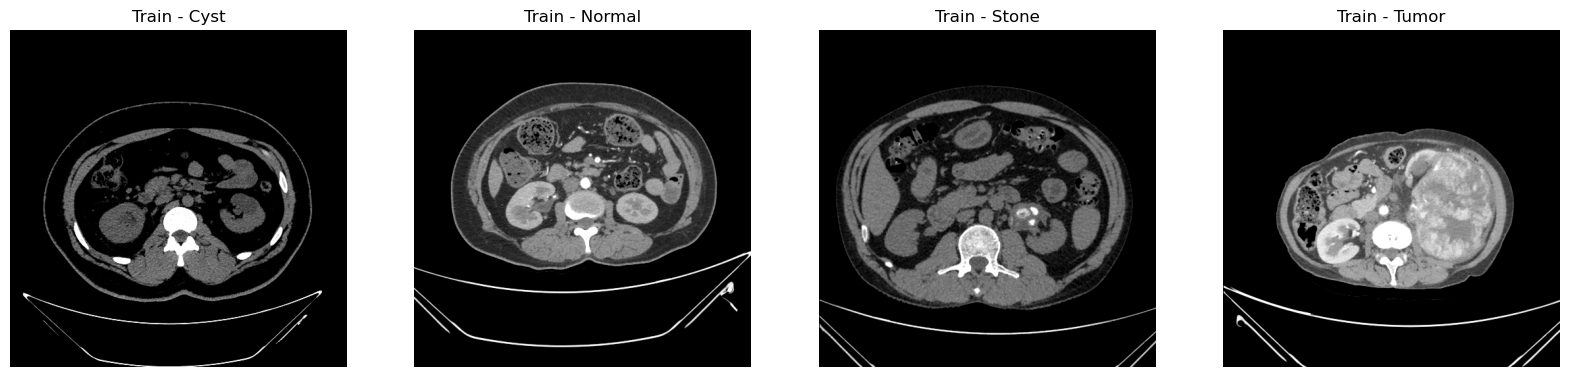

In [22]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


def visualize_samples(directory, subset='train'):
    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))
    

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{subset.capitalize()} - {class_name}')
        axes[i].axis('off')

    plt.show()

visualize_samples(base_dir, 'train')


In [23]:
def preprocess_image(image):

    # resizing and normalizing images
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image

def preprocess_sequence(image_paths):
    
    # loading and preprocessing 
    images = [preprocess_image(tf.image.decode_jpeg(tf.io.read_file(img))) for img in image_paths]
    return tf.stack(images, axis=0)  # Stack into a single tensor for 3D CNN or CNN-LSTM


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


In [25]:
# initializing train generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42  
)

# setting class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# validation and test data generators
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42  
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42 
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [26]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, GlobalAveragePooling3D
from tensorflow.keras import Input, Model


# 3 frames in every sequence
sequence_length = 3  

# input specifications
inputs = Input(shape=(sequence_length, IMG_HEIGHT, IMG_WIDTH, 1))

# 3D Convolutional layers 
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x) 

x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

x = Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

# Global pooling for all features
x = GlobalAveragePooling3D()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(len(classes), activation='softmax')(x)

# complie the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 224, 224, 1)]  0         
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 224, 224, 64)   1792      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 112, 112, 64)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 112, 112, 128)  221312    
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 56, 56, 128)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 56, 56, 256)    8849

START OF TRAIN WITH LEARNING RATE SCHEDULER -1
USING LEARNING RATE SCHEDULER -1 WITH EXPONENETIAL DECAY

In [27]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)



In [28]:
EPOCHS = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[lr_callback]
)


Epoch 1/20
623/623 [==============================] - 402s 645ms/step - loss: 1.1800 - accuracy: 0.5360 - val_loss: 0.9861 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 2/20
623/623 [==============================] - 340s 545ms/step - loss: 1.0659 - accuracy: 0.6475 - val_loss: 0.9518 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 3/20
623/623 [==============================] - 336s 540ms/step - loss: 1.0262 - accuracy: 0.6496 - val_loss: 0.9090 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 4/20
623/623 [==============================] - 334s 536ms/step - loss: 0.9448 - accuracy: 0.6613 - val_loss: 0.8034 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 5/20
623/623 [==============================] - 334s 536ms/step - loss: 0.8739 - accuracy: 0.6772 - val_loss: 0.7500 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 6/20
623/623 [==============================] - 335s 538ms/step - loss: 0.7760 - accuracy: 0.6987 - val_loss: 0.6990 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 7/20
623/623 [==========================

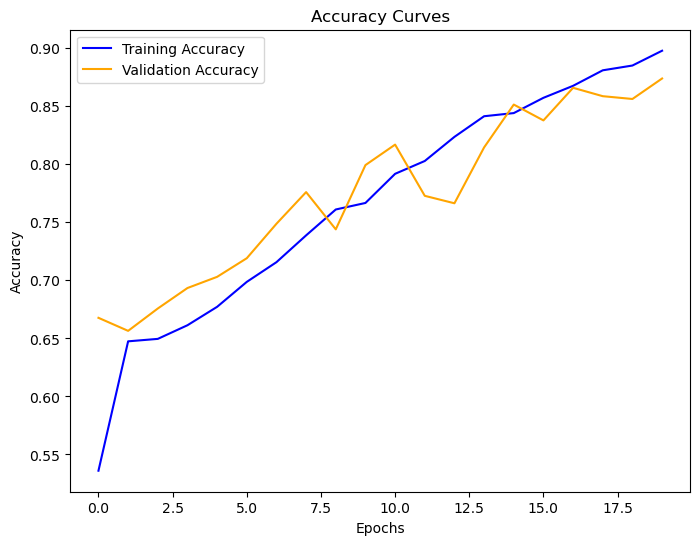

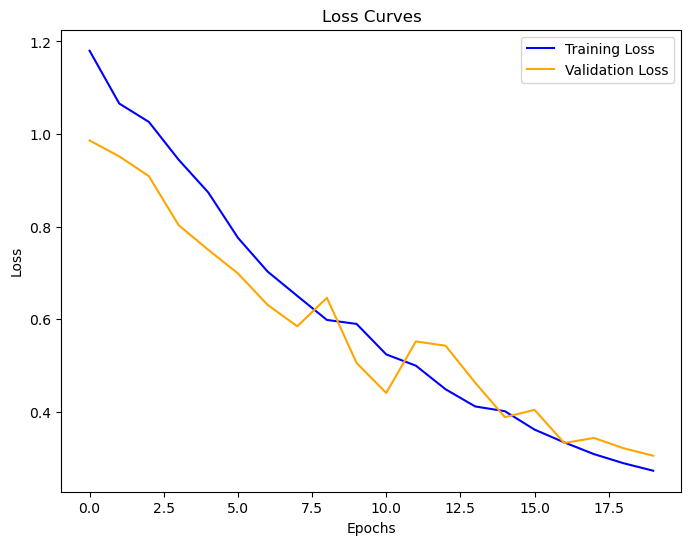

In [ ]:
# Function to plot training history
def plot_training_history(history):

    # accuracy curves val v/s train
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # loss curves val v/s train
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# calling the function to plot training history
plot_training_history(history)


THIS LEARNING RATE SCHEDULER SEEMS UNSATISFACTIRY AS THE VAL SET NOT ABLE TO GENERALIZE WELL SUGGESTING LEARNING RATE TOO SMALL IN LATER EPOCHS

END OF LEARNING RATE SCHEDULER-1

START OF LEARNING RATE SCHEDULER-2 DECREMENTED MANUALLY 

RE TRAINING MODEL WITH NEW LR-2

Epoch 1/20
623/623 [==============================] - 333s 533ms/step - loss: 1.0169 - accuracy: 0.6008 - val_loss: 0.8429 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 2/20
623/623 [==============================] - 333s 534ms/step - loss: 0.8303 - accuracy: 0.6815 - val_loss: 0.8513 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 3/20
623/623 [==============================] - 334s 537ms/step - loss: 0.7553 - accuracy: 0.7090 - val_loss: 0.6983 - val_accuracy: 0.7279 - lr: 0.0010
Epoch 4/20
623/623 [==============================] - 334s 536ms/step - loss: 0.6465 - accuracy: 0.7550 - val_loss: 0.5748 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 5/20
623/623 [==============================] - 344s 553ms/step - loss: 0.5369 - accuracy: 0.8011 - val_loss: 0.6456 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 6/20
623/623 [==============================] - 347s 557ms/step - loss: 0.4227 - accuracy: 0.8412 - val_loss: 0.4124 - val_accuracy: 0.8419 - lr: 8.0000e-04
Epoch 7/20
623/623 [======================

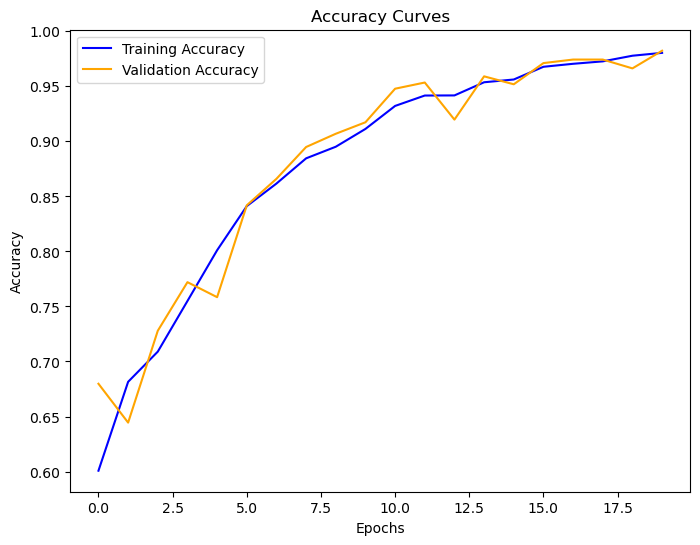

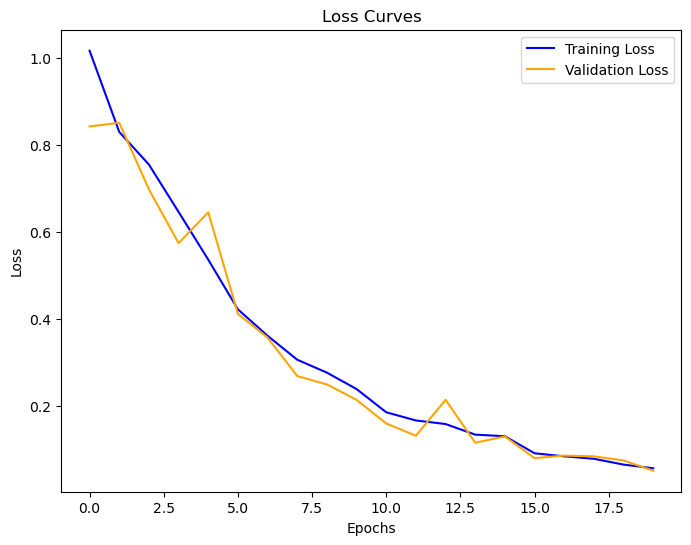

In [ ]:
# saving model configuration
model_config = model.get_config()

# re initializing model so it doesnt memorize previous weights from previous training
model = tf.keras.Model.from_config(model_config)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


def manual_decay(epoch, lr):
    # epoch 1-5 allowing model to learn at normal rate
    if epoch < 5:
        return 0.001
    # epoch 5-10 dropping rate by 20%   
    elif epoch < 10:
        return 0.001 * 0.8
    # further drop    
    elif epoch < 15:
        return 0.001 * (0.8)**2 
    else:
        return 0.001 * (0.8)**3 


lr_callback_manual = tf.keras.callbacks.LearningRateScheduler(manual_decay)

history_manual = model.fit(
    train_generator,
    validation_data=validation_generator,
    # 20
    epochs=EPOCHS, 
    callbacks=[lr_callback_manual]
)

# plotting after re training
plot_training_history(history_manual)


        


END OF EXPERIMENT WITH MANUAL LEARNING RATE(2)
CONCLUSION 12-20 EPOCHS FROM BOTH EXPERIMENTS LEARNING RATE 1,2 SHOW MINIMAL INCREMENT DUE TO VERY LOW LEARNING RATE IN LAST 5 EPOCHS, EVEN IF LEARNING RATE WAS HIGH ENOUGH THE MODEL WAS CLOSE TO OVERFITTING.
SUGGESTING MODEL AFTER 15 EPOCHS TENDS TO OVERFITT.

START OF RE TRAIN WITH LEARNING RATE 3 , WITH REVISED NO OF EPOCHS=15

Epoch 1/15
623/623 [==============================] - 413s 662ms/step - loss: 1.0127 - accuracy: 0.6033 - val_loss: 0.8875 - val_accuracy: 0.6589 - lr: 0.0010
Epoch 2/15
623/623 [==============================] - 344s 552ms/step - loss: 0.8143 - accuracy: 0.6924 - val_loss: 0.7894 - val_accuracy: 0.7183 - lr: 9.5000e-04
Epoch 3/15
623/623 [==============================] - 349s 560ms/step - loss: 0.7438 - accuracy: 0.7107 - val_loss: 0.6719 - val_accuracy: 0.7456 - lr: 9.0250e-04
Epoch 4/15
623/623 [==============================] - 348s 558ms/step - loss: 0.6493 - accuracy: 0.7472 - val_loss: 0.5913 - val_accuracy: 0.7616 - lr: 8.5737e-04
Epoch 5/15
623/623 [==============================] - 348s 559ms/step - loss: 0.5608 - accuracy: 0.7837 - val_loss: 0.5863 - val_accuracy: 0.7705 - lr: 8.1451e-04
Epoch 6/15
623/623 [==============================] - 389s 624ms/step - loss: 0.4974 - accuracy: 0.8060 - val_loss: 0.5037 - val_accuracy: 0.7921 - lr: 7.7378e-04
Epoch 7/15
623/623 [======

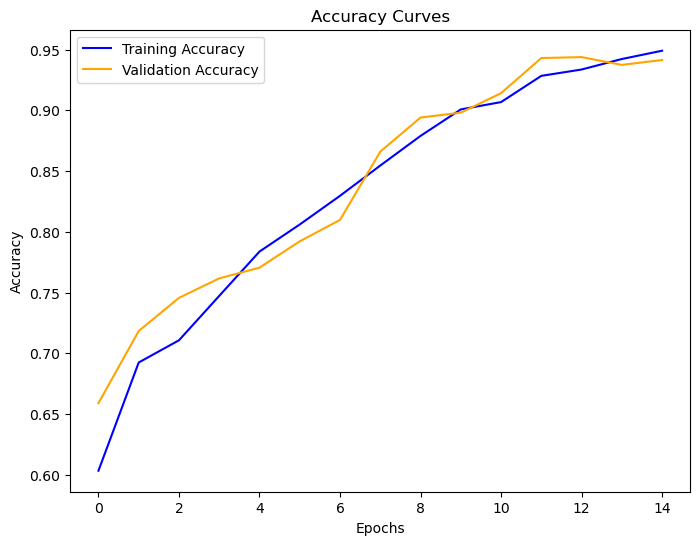

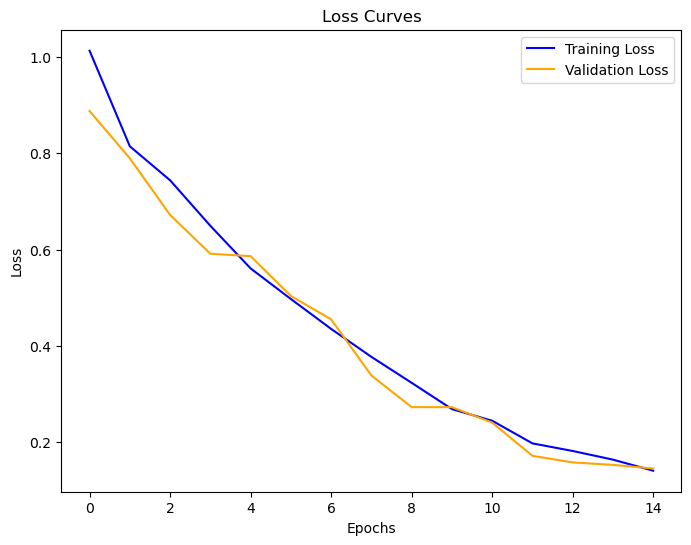

In [39]:
# saving model configuration
model_config = model.get_config()

# re initializing model so it doesnt memorize previous weights from previous training
model = tf.keras.Model.from_config(model_config)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


def manual_decay_2(epoch, lr):
    # slow decay of approx 5% for every step
    return 0.001 * (0.95 ** epoch)

       

lr_callback_manual_2 = tf.keras.callbacks.LearningRateScheduler(manual_decay_2)

history_manual_2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    # 20
    epochs=15, 
    callbacks=[lr_callback_manual_2]
)

# plotting after re training
plot_training_history(history_manual_2)

78/78 [==============================] - 25s 315ms/step


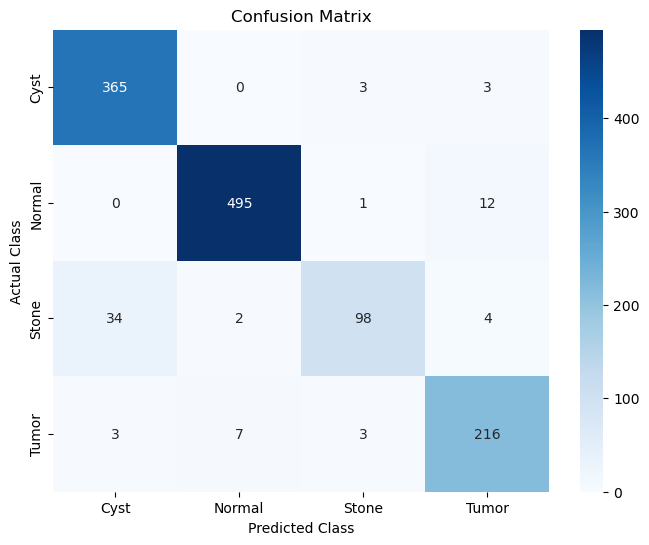

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.91      0.98      0.94       371
      Normal       0.98      0.97      0.98       508
       Stone       0.93      0.71      0.81       138
       Tumor       0.92      0.94      0.93       229

    accuracy                           0.94      1246
   macro avg       0.94      0.90      0.92      1246
weighted avg       0.94      0.94      0.94      1246



In [40]:

def evaluate_model(model, test_generator):

    # prediction on test data set
    test_steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    #  confusion matrix

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()


    # classification report

    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)


evaluate_model(model, test_generator)


In [41]:
# performance on test data

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")




78/78 [==============================] - 16s 202ms/step - loss: 0.1610 - accuracy: 0.9422
Test Loss: 0.1610187441110611
Test Accuracy: 0.942215085029602


Adjusted class weights for stone and fine-tuning: {0: 0.8387259858442871, 1: 0.6127801034228023, 2: 2.712261580381471, 3: 1.3635616438356164}
Epoch 1/7
623/623 [==============================] - 335s 536ms/step - loss: 0.1499 - accuracy: 0.9531 - val_loss: 0.1208 - val_accuracy: 0.9535
Epoch 2/7
623/623 [==============================] - 334s 536ms/step - loss: 0.1357 - accuracy: 0.9529 - val_loss: 0.1178 - val_accuracy: 0.9575
Epoch 3/7
623/623 [==============================] - 335s 538ms/step - loss: 0.1329 - accuracy: 0.9547 - val_loss: 0.1557 - val_accuracy: 0.9270
Epoch 4/7
623/623 [==============================] - 335s 538ms/step - loss: 0.1201 - accuracy: 0.9586 - val_loss: 0.0961 - val_accuracy: 0.9631
Epoch 5/7
623/623 [==============================] - 345s 553ms/step - loss: 0.1194 - accuracy: 0.9596 - val_loss: 0.1110 - val_accuracy: 0.9543
Epoch 6/7
623/623 [==============================] - 337s 541ms/step - loss: 0.1108 - accuracy: 0.9606 - val_loss: 0.0978 - val_accur

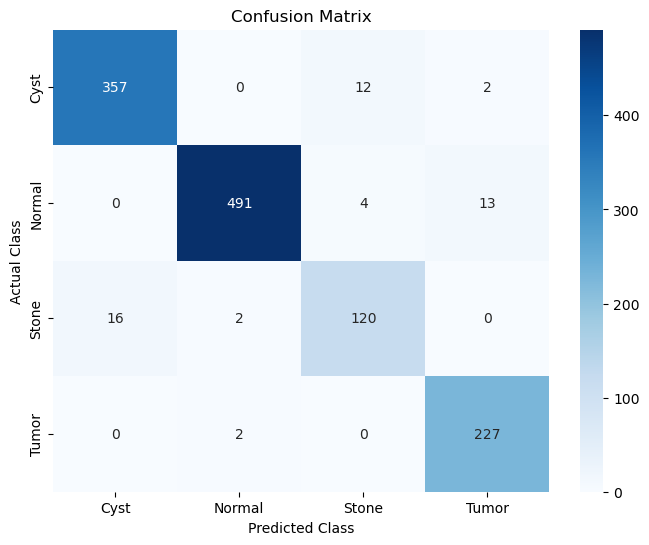

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.96      0.96      0.96       371
      Normal       0.99      0.97      0.98       508
       Stone       0.88      0.87      0.88       138
       Tumor       0.94      0.99      0.96       229

    accuracy                           0.96      1246
   macro avg       0.94      0.95      0.94      1246
weighted avg       0.96      0.96      0.96      1246



In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# fine tune class weights

class_weights = compute_class_weight(
class_weight='balanced',
classes=np.unique(train_generator.classes),
y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))

#altering weight for stone as it has least amt of imgs
# increasing weight for stone by 20%
class_weights_dict[2] *= 1.2


print("Adjusted class weights for stone and fine-tuning:", class_weights_dict)

# compliing the model
# very low learning rate as model has retained info from previous training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fine tune epochs = 7  
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=7,
    class_weight=class_weights_dict 
)

# re evaluation 
evaluate_model(model, test_generator)

Conclusion: From best parameters found in cnn-file2 using random search appears to give good results.
Fine tuning of weights to increase accuracy of classes with lesser imgs
3D CNN outperforms 2D CNN in almost every aspect suggesting the datsets with sequential frames work best with 3D CNN.